# __Cointegration in Cryptocurrencies Price Series__

__Javier Albert__       
jav.albert@gmail.com  
__Last Edit:__ 04 Sept 2018

## __Summary__

This project explores the presence of cointegration between cryptocurrencies price series with the goal of developing statistical arbitrage trading strategies. __Using statistical tests (Dickey-Fuller, Hurst Exponent, Johansen Test)__ we were able to identify several cointegrating relationship with strong mean-reverting behavior, making them solid candidates to build automated trading strategies.

At the end of this notebook we chose 2 specific price series. __Both selected series passed the Dickey-Fuller Test with 99% confidence and have a Hurst Exponent of 0.28-0.31__ in the explored period (01 April 2018 to 31 August 2018), indicating strong cointegration and mean-reversion. The selected series are:

__BTG__ + 0.171313 * __DSH__  

0.008474 * __ETH__ + 0.110181 * __XMR__ - 0.098357 * __DSH__ + 0.871111 * __OMG__

__In the next notebook__, we will use this 2 price series to explore the Half Life of Mean Reversion and to __develop and backtest a a real trading strategy based on Bollinger Bands and Kalman Filters.__

In [1]:
import pandas as pd
f_df = pd.read_csv('first.csv', index_col=0)
s_df = pd.read_csv('second.csv', index_col=0)

In [2]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(25,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
f_df.plot(ax=ax1, color = 'green')
s_df.plot(ax=ax2);

## __Table of Contents__

- Cointegration and Statistical Arbitrage
- Why Cryptocurrencies?
- The Tradable Universe
- Data Preprocessing
- Data Exploration
- Testing for Cointegration:
    - Augmented Dickey-Fuller Test
    - Hurst Exponent
    - Johansen Test
- Results
- Conclusions

## __Short Introduction to Cointegration and Statistical Arbitrage__

Most stock prices behave as random walks. This means that both the current price and the historical prices have no predictive power over the future value of the price series. On any given time, and without any further information, the probability of the stock price moving up or moving down is identical.

As traders, we would be fascinated to find a stock with a mean-reverting behavior. That stock would be relatively easy to trade since we would just short the stock when the price is above the mean and long the stock when the price is below the mean, "knowing" the price will revert to the mean and secure us a profit.

These kind of stocks are extremely rare, but fortunately we are not limited to prefabricated price series (assets traded in the public exchanges or markets) and we can build our own as a linear combination of prefabricated price series. If for example we take 2 stocks that behave similarly (rise and fall together) we could create a synthetic price series by taking the spread between the 2 stocks. __If the spread is stationary then the 2 stocks are said to be cointegrated__ and we can trade the spread. This means to short the spread when it is above the mean (the 2 original stocks are further apart than usual) or long the spread when it is below the mean (the 2 original stocks are close together than usual). This is called __Pairs Trading__ and was introduced by Gerry Bamberger from Morgan Stanley in the 1980'. The same idea can be expanded to more than 2 stocks since we can find linear combinations between many stocks that results on a stationary residual price series.  

Another beauty of Pairs Trading (and statistical arbitrage in general) is that since we are long and short at the same time we are mostly __market-neutral__. This means that we can protect ourselves from market regimes, trends or swings.

There is a lot of literature around Pairs Trading, Statistical Arbitrage and Cointegration. Some of the introductory material:  
1) ["Basic Statistical Arbitrage: Understanding the Math Behind Pairs Trading"](https://www.youtube.com/watch?v=g-qvFjvyqcs)  
2) ["Cointegrated Time Series Analysis for Mean Reversion Trading"](https://www.quantstart.com/articles/Cointegrated-Time-Series-Analysis-for-Mean-Reversion-Trading-with-R)  
3) ["Basics of Statistical Mean Reversion Testing"](https://www.quantstart.com/articles/Basics-of-Statistical-Mean-Reversion-Testing)  

## __Why Cryptocurrencies?__

As expressed before, statistical arbitrage strategies are mostly __dollar-neutral, market-neutral, long/short trading strategies__. The main ingredient of these strategies are assets whose price series behave similarly (rise and fall together).

So why should we look at cryptocurrencies? First because cryptocurrencies are extremely volatile (Bitcoin price alone has a typical 5%-10% daily volatility), which creates a very risky ans hostile environment for investors and traders. Developing market-neutral strategies is of great interest in order to benefit from this market without fearing the big swings in price.

Second because there are __more that 2000 cryptocurrencies available__, and they all tend to behave together against USD. This gives us a very __fertile land__ to look for cointegrating price series and implement statistical arbitrage trading strategies.

## __The Tradable Universe__

Since our goal is to develop long/short trading strategies we will limit our universe of assets to only those cryptocurrencies that can be shorted on major exchanges. From the ~2000 cryptocurrencies currently listed on CoinMarketCap __only 14 of them are shortable__ on Bitfinex. They are:

In [3]:
token_list = ['BTC', 'ETH', 'XRP', 'BCH', 'EOS', 'LTC', 'BTG', 'XMR', 'ZEC', 'NEO', 'ETC', 'DSH', 'IOT', 'OMG']

## __Data Preprocessing__

We download the price series of every cryptocurrency listed before in the format of OHLCV. We only keep the opening price. Our analysis will be done on a __5 months period__ from 01 April 2018 to 31 August 2018. The frequency of the data is hourly and since there are 153 days on that period we are expecting our dataset to have 184*24 = 3672 datapoints

The raw data in JSON form was taken from [CoinAPI.io](https://www.coinapi.io/) through Rest API requests. We will use the data and convert it to a dataframe.

In [4]:
import json
import pandas as pd
from pandas.io.json import json_normalize
import numpy as np

datetime_index = pd.date_range('2018-04-01 00:00:00', '2018-08-31 23:00:00', freq='H') # Generate datetime index for dataframe
df = pd.DataFrame(index = datetime_index) # Create empty dataframe with datetime index

for token in token_list: # Run over the token list
    with open('{}.json'.format(token)) as json_data: # Open JSON file
        full_data = json_normalize(json.load(json_data)) # Convert JSON file to dataframe    
        price_data = full_data['price_open'] # Take the price_open column
        date = full_data['time_period_start'] # Take the time_period_start column
        formatted_date = [] # Initialize array to store the time_period_start after formatting
        for i in date: # Run over each row 
            formatted_date.append(pd.to_datetime(i[0:4] + '-' + i[5:7] + '-' + i[8:10] + ' ' + i[11:13] + ':00:00')) # Reformat the date to math the datetime index
        tokendf = pd.DataFrame(index = list(formatted_date)) # Create dataframe with the reformatted dates
        tokendf['{}'.format(token)] = price_data.values # Add open price to the new dataframe
        df = pd.concat([df, tokendf], axis=1, sort=False) # Add column to general dataframe by concatenation

Let's now explore the resulting dataframe and check for strange behaviour (non-realistic mix or max value, missing data, price discontinuities, etc)

In [5]:
df.head()

,BTC,ETH,XRP,BCH,EOS,LTC,BTG,XMR,ZEC,NEO,ETC,DSH,IOT,OMG
2018-04-01 00:00:00,6925.3,393.65,0.50019,682.77,5.9130,115.96,43.728,178.36,184.87,50.015,14.307,305.22,1.072000,8.1890
2018-04-01 01:00:00,6980.7,394.45,0.50268,689.10,5.9359,116.73,43.900,179.92,184.54,50.210,14.435,307.00,1.081200,8.2330
2018-04-01 02:00:00,6998.6,397.15,0.50434,695.50,5.9562,117.33,43.851,181.16,188.02,50.120,14.367,307.90,1.082500,8.2180
2018-04-01 03:00:00,6923.9,393.90,0.49882,692.01,5.9176,116.36,43.330,179.17,186.47,49.586,14.214,304.41,1.083294,8.1580
2018-04-01 04:00:00,6920.0,393.27,0.49732,692.00,5.9105,116.30,43.480,179.50,187.08,49.592,14.238,302.97,1.080300,8.1317


In [6]:
df.describe()

,BTC,ETH,XRP,BCH,EOS,LTC,BTG,XMR,ZEC,NEO,ETC,DSH,IOT,OMG
count,3671.000000,3671.000000,3671.000000,3670.000000,3670.000000,3670.000000,3669.000000,3670.000000,3671.000000,3668.00000,3669.000000,3670.000000,3669.000000,3668.000000
mean,7399.709678,499.358282,0.549298,897.320635,9.766896,103.415778,39.437454,156.786629,213.341937,45.34750,16.243161,293.312319,1.274347,9.548883
std,999.492710,134.817501,0.164258,303.527996,3.876335,32.419767,17.426179,49.459350,56.904594,19.61326,2.657817,100.417605,0.515394,4.109400
min,5777.100000,253.780000,0.252390,480.490000,4.266900,50.500000,15.190000,79.667000,125.220000,14.18500,10.577000,134.510000,0.406500,3.269100
25%,6545.000000,412.445000,0.446775,691.770000,6.978900,77.971000,25.810000,122.320000,171.845000,31.32150,14.415000,226.000000,0.965190,6.833550
50%,7260.000000,475.340000,0.495990,797.240000,8.604700,97.496000,32.684000,140.640000,195.820000,39.66800,16.011000,265.015000,1.100200,8.969550
75%,8167.237787,598.915000,0.667300,1095.475000,12.338500,128.255000,47.798000,189.785000,249.530000,59.63550,17.479000,361.345000,1.718000,12.390250
max,9959.400000,838.000000,0.955070,1831.800000,22.504000,182.280000,89.320000,297.800000,377.000000,93.51000,25.323000,540.990000,2.685200,19.746000


We see that the min-max values are reasonable. We also see that we have some few __missing values__. Let's check how many missing values:

In [7]:
missing_rows = pd.isnull(df).any(1).nonzero()[0] # Get all the rows where we have at least one NaN
missing_df = df.iloc[missing_rows] # Get the index of those missing rows as dataframe
print('There are ' + str(missing_df.shape[0]) + ' rows with missing values') # Print the number of missing rows
missing_df.head(missing_df.shape[0]) # Show the missing rows as dataframe

There are 6 rows with missing values


,BTC,ETH,XRP,BCH,EOS,LTC,BTG,XMR,ZEC,NEO,ETC,DSH,IOT,OMG
2018-04-11 09:00:00,6856.795179,416.81,0.48790,NaN,NaN,114.310,NaN,NaN,181.19,NaN,NaN,NaN,NaN,NaN
2018-06-05 11:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-06-05 14:00:00,7419.200000,587.86,0.65751,1065.50,13.5670,NaN,NaN,162.49,227.23,NaN,14.900,309.24,1.69440,NaN
2018-06-27 22:00:00,6120.000000,435.56,0.46954,711.59,7.9911,80.177,24.369,127.60,162.27,NaN,15.343,226.55,0.96997,7.2220
2018-06-28 16:00:00,6101.733365,435.04,0.45905,696.29,7.8200,79.331,24.680,130.51,162.94,30.029,15.351,221.12,NaN,7.1214
2018-08-31 15:00:00,6920.000000,277.02,0.32921,535.50,6.1481,59.952,21.797,107.16,142.51,19.303,NaN,184.89,0.69642,NaN


We have 6 rows with missing values from a total of 3672 so it is not very problematic. We could just delete the rows where we have missing values but we will do something else instead. We say that if a value is missing we will just replace the entire row with the the latest full row available. In other words we will just copy the values from an hour before.

In [8]:
for row in missing_rows:
    df.iloc[row] = df.iloc[row-1] # Replace missing rows with last available row

Let's check the replacement worked. We should have 3672 rows in every column

In [9]:
df.describe()

,BTC,ETH,XRP,BCH,EOS,LTC,BTG,XMR,ZEC,NEO,ETC,DSH,IOT,OMG
count,3672.000000,3672.000000,3672.000000,3672.000000,3672.000000,3672.000000,3672.000000,3672.000000,3672.000000,3672.000000,3672.000000,3672.000000,3672.000000,3672.000000
mean,7399.719390,499.382792,0.549326,897.303508,9.766996,103.423566,39.440663,156.789918,213.347840,45.349873,16.241250,293.320512,1.274317,9.548118
std,999.350092,134.806327,0.164244,303.484315,3.876167,32.412343,17.419434,49.445902,56.897517,19.605255,2.657734,100.390443,0.515270,4.108229
min,5777.100000,253.780000,0.252390,480.490000,4.266900,50.500000,15.190000,79.667000,125.220000,14.185000,10.577000,134.510000,0.406500,3.269100
25%,6545.000000,412.467500,0.446787,691.720000,6.978700,77.993000,25.810000,122.320000,171.857500,31.321500,14.414750,226.000000,0.965243,6.833550
50%,7263.250000,475.345000,0.496140,797.240000,8.604700,97.506000,32.693500,140.670000,195.835000,39.687500,16.007000,265.035000,1.100150,8.971450
75%,8167.168894,598.872500,0.667250,1095.425000,12.339750,128.245000,47.724500,189.755000,249.515000,59.623500,17.476000,361.315000,1.718000,12.387000
max,9959.400000,838.000000,0.955070,1831.800000,22.504000,182.280000,89.320000,297.800000,377.000000,93.510000,25.323000,540.990000,2.685200,19.746000


## __Data Exploration__

Before we plot the data it is better if we __normalize__ it, otherwise we won't see anything useful on the plot. This is because BTC is in the range of 1000-10000 USD while XRP is in the range of 0.25-1 USD for example.

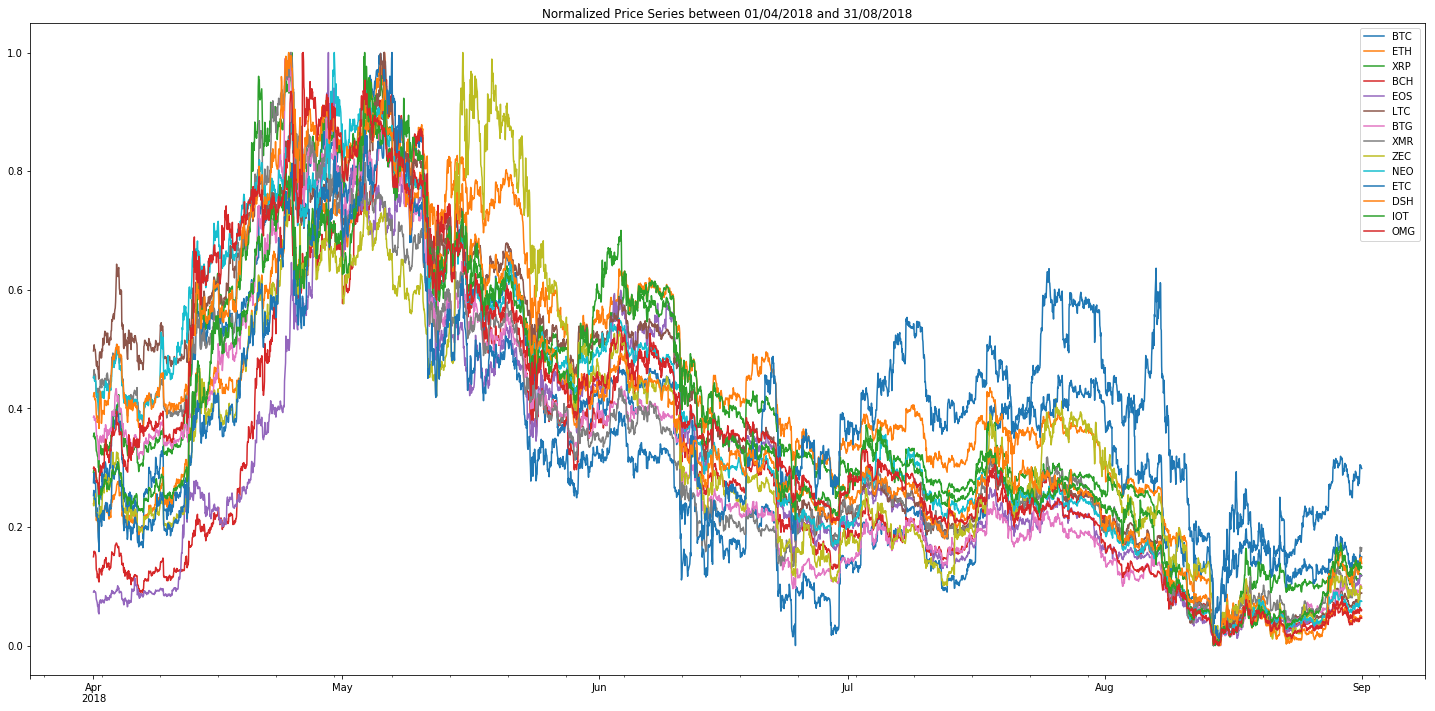

In [10]:
import matplotlib.pyplot as plt
normalized_df=(df-df.min())/(df.max()-df.min()) # normalize the price series
normalized_df.plot(figsize=(25,12), title='Normalized Price Series between 01/04/2018 and 31/08/2018'); # Plot

## __Testing for Cointegration__

As explained, pairs trading consists on finding a __linear combination between two assets that results on a stationary price series__. The hedge ratio represents how much of asset A to buy relative to how much of asset B to sell. It is not always possible to make a stationary linear combination, but our first goal is to understand how we can choose the hedge ratio that gives us the best possible candidate for that specific trading pair.

This is by itself a delicate matter where advanced models use Kalman Filters and other complex methodologies. We will limit ourselves to a simplistic approach based on __linear regression__ were we find the regression coefficients that minimizes the squared error. That will give us the hedge ratio, and the price series to be tested for stationarity will be the residuals of the regression.

We will test it for stationarity using different __statistical tests__. Each test looks for different attributes that are representative of stationarity. The tests that will be explored here are:  
__1) Augmented Dickey-Fuller Test__  
__2) Hurst Exponent__  
__3) Johansen Test__

### __Augmented Dickey-Fuller Test__

Given a time series, the Dickey–Fuller test tests the null hypothesis that a unit root is present in an autoregressive model. The alternative hypothesis is stationarity or trend-stationarity.

__The model:__  
$\Delta y_t = \alpha + \beta t + \gamma y_{t-1} + \delta_1 \Delta y_{t-1} + \cdots + \delta_{p-1} \Delta y_{t-p+1} + \varepsilon_t$ 

here $\alpha$  is a constant, $\beta$  the coefficient on a time trend and $p$ the lag order of the autoregressive process. Imposing the constraints $\alpha = 0$ and $\beta = 0$ corresponds to modelling a random walk and using the constraint $\beta =0$ corresponds to modeling a random walk with a drift. By including lags of the order p the ADF formulation allows for higher-order autoregressive processes. This means that the lag length p has to be determined when applying the test.

__The intuition behind the test is that if the series is integrated then the lagged level of the series ($y_{t-1}$) will provide no relevant information in predicting the change in $y_{t}$ besides the one obtained in the lagged changes ($\Delta y_{t-k}$). In this case the $\gamma = 0$ and null hypothesis is not rejected.__

The unit root test is then carried out under the null hypothesis $\gamma = 0$ against the alternative hypothesis of $\gamma < 0$.

More information about the Augmented Dickey-Fuller test is widely available online

In [11]:
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

t_results_table = pd.DataFrame(columns=token_list, index=token_list) # Initizalize empty datafrane with token_list as both columns and indexes
p_results_table = pd.DataFrame(columns=token_list, index=token_list) # Initizalize empty datafrane with token_list as both columns and indexes

# Loop every column and every row
for row in token_list:
    for column in token_list:
        # If column is the same as row then set NaN as the result of the ADF test
        if row == column: 
            t_results_table[column][row] = np.nan
            p_results_table[column][row] = np.nan
        else: 
            regression = sm.OLS(df[row], sm.add_constant(df[column])).fit().params # Apply OLS     
            residual = df[row]-regression[1]*df[column]-regression[0] # Build the residual price series
            adf_results = adfuller(residual) # Calculate the ADF test on the residuals
            t_results_table[column][row] = adf_results[0] # Save the results to table
            p_results_table[column][row] = adf_results[1] # Save the results to table

Let's have a look at the results of the test. Below we can see a table with the t-statistic value of each token combination. __The table is not symmetric__ since choosing asset A or asset B as the independant variable for the linear regression results on different residual price series. The rows are the independent variables here.

In [12]:
t_results_table.head(len(token_list))

,BTC,ETH,XRP,BCH,EOS,LTC,BTG,XMR,ZEC,NEO,ETC,DSH,IOT,OMG
BTC,NaN,-1.22945,-1.7246,-1.99414,-2.08736,-1.84515,-2.57446,-2.42347,-2.12048,-1.98492,-2.07346,-2.14027,-2.08607,-1.6707
ETH,-0.243038,NaN,-1.71393,-2.66774,-3.2039,-2.24812,-1.77755,-1.52696,-2.54329,-2.14029,-1.88821,-1.6828,-2.67272,-1.85439
XRP,-1.15033,-1.77916,NaN,-2.1271,-2.41512,-2.97958,-2.9138,-2.42263,-2.1695,-3.25969,-1.95551,-2.93941,-3.43041,-4.05269
BCH,-1.62674,-2.64012,-2.30634,NaN,-4.16131,-2.51589,-2.05782,-2.05849,-3.07847,-2.45546,-2.2538,-2.26574,-3.22623,-2.31411
EOS,-2.05048,-3.55506,-2.83416,-4.31852,NaN,-2.92061,-2.80077,-2.59132,-2.92755,-2.55484,-2.18188,-2.71141,-3.55149,-2.48796
LTC,-1.08277,-2.50026,-2.65641,-1.9135,-2.44525,NaN,-2.46565,-1.85784,-2.36832,-3.27451,-1.70869,-2.68054,-3.17177,-3.32435
BTG,-2.1931,-1.82637,-2.89991,-2.00114,-2.42433,-2.54997,NaN,-2.99499,-2.15572,-3.22293,-2.13298,-3.51658,-2.45438,-3.60149
XMR,-2.01006,-1.75872,-2.55539,-1.90354,-2.13839,-2.05899,-3.04186,NaN,-2.07652,-2.56741,-2.29294,-3.34407,-2.24977,-2.95928
ZEC,-1.9776,-2.75739,-2.443,-3.06853,-2.71142,-2.72093,-2.43466,-2.3231,NaN,-2.53372,-2.06614,-2.31378,-2.81391,-2.28828
NEO,-1.29179,-2.01648,-3.16216,-2.03935,-2.12621,-3.25009,-3.09754,-2.38258,-2.14505,NaN,-1.92369,-3.32532,-2.60364,-4.23324


Now, we will categorize the results. We will use the critical values of the t-statistics and the p-value to determine if the specific combination is very likely to be a cointegrating pair, likely to be a cointegrating pair or not likely to be a cointegrating pair.

__"1"__ - The pair is very likely to be cointegrating. __p-value < 0.05 & t-stat > 99% certainty__.  
__"2"__ - The pair is very likely to be cointegrating. __p-value < 0.05 & t-stat > 95% certainty__.  
__"nan"__ - Else

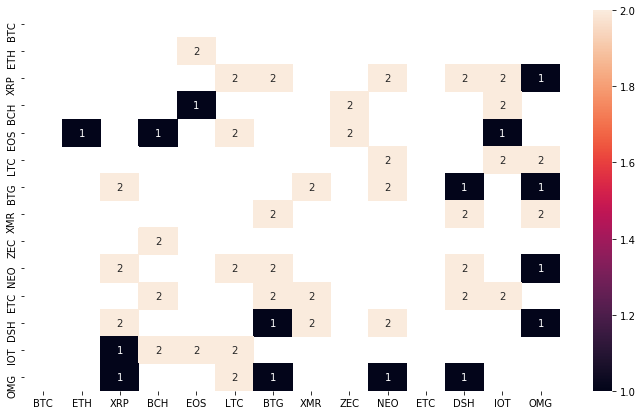

In [13]:
# Define function that gets a cell (value) and compares to critical values of the ADF test
def tstat(cell):
    if cell < adf_results[4]['1%']:
        ret = 1
    elif cell < adf_results[4]['5%']:
        ret = 2
    else:
        ret = np.nan
    return ret

def convp(cell):
    if cell < 0.05:
        ret = 1
    else:
        ret = np.nan
    return ret

# Apply tstat function to every cell on table
tstat_table = t_results_table.applymap(tstat)
pvalue_table = p_results_table.applymap(convp)

results_table = pd.DataFrame(tstat_table.values*pvalue_table.values, columns=tstat_table.columns, index=tstat_table.index)

# Plot results with Seaborn
import seaborn as sns
fig = plt.figure(figsize=(12,7))
ax = sns.heatmap(results_table.values.astype(float), xticklabels = tstat_table.columns, yticklabels = tstat_table.columns, annot = True)

We can easily see that there are many pairs that appear to be cointegrating. __Among them 15 with 99% probability__ based on the Augmented Dickey-Fuller test.

### __Hurst Exponent__

__As Ernest P. Chan explains in the book "Algorithmic Trading":__

Intuitively speaking, a "stationary" price series means that the prices diffuse from its initial value more slowly than a geometric random walk would. Mathematically, we can determine the nature of the price series by measuring this speed of diffusion. The speed of difussion can be characterized by the variance

$Var(\tau) = \langle | z(t+\tau) - z(t)|^{2} \rangle$

where z is the log prices, $\tau$ is an arbitrary time lag, and $\langle \rangle$ is an average over all t's. For a geometric random walk, we know that

$Var(\tau) = \langle | z(t+\tau) - z(t)|^{2} \rangle \approx \tau$

The $\approx$ means that this relationship turns into an equality with some proportionality constant for large $\tau$, but it may deviate from a straight line for small $\tau$. But if the (log) price series is mean reverting or trending the last equation won't hold. Instead, we can write: 

$Var(\tau) = \langle | z(t+\tau) - z(t)|^{2} \rangle \approx \tau^{2H}$

where we have defined the Hurst exponent H. __For a price series exhibiting geometric random walk H = 0.5. But for a mean reverting series, H < 0.5, and for a trending series, H > 0.5.__ As H decreases toward zero, the price series is more mean reverting, and as H increases toward 1, the price series is increasingly trending.

In [14]:
from numpy import cumsum, log, polyfit, sqrt, std, subtract
from numpy.random import randn

def hurst(ts):
    # Create the range of lag values
    lags = range(2, 100)

    # Calculate the array of the variances of the lagged differences
    tau = [sqrt(std(subtract(ts[lag:], ts[:-lag]))) for lag in lags]

    # Use a linear fit to estimate the Hurst Exponent
    poly = polyfit(log(lags), log(tau), 1)

    # Return the Hurst exponent from the polyfit output
    return poly[0]*2.0

Hurst_results_table = pd.DataFrame(columns=token_list, index=token_list)

for row in token_list:
    for column in token_list:
        if row == column:
            Hurst_results_table[column][row] = np.nan
        else:
            regression = sm.OLS(df[row], sm.add_constant(df[column])).fit().params    
            residual = df[row]-regression[1]*df[column]-regression[0]
            hurst_results = hurst(residual)
            Hurst_results_table[column][row] = hurst_results

Let's have a look at the results of the test using Seaborn. The smaller the value the more mean-reverting the series is.

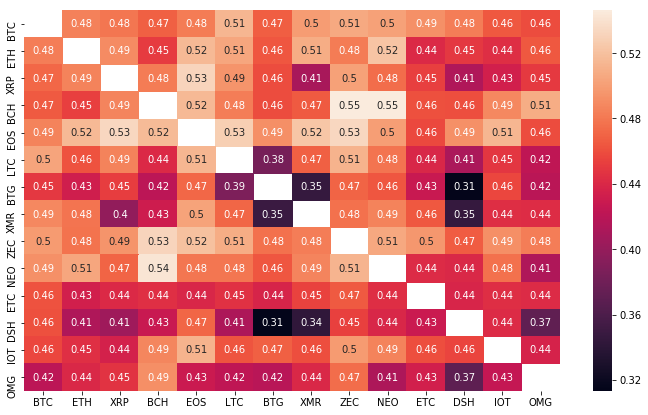

In [15]:
fig = plt.figure(figsize=(12,7))
ax = sns.heatmap(Hurst_results_table.values.astype(float), xticklabels = Hurst_results_table.columns, yticklabels = Hurst_results_table.columns, annot = True)

### __Johansen Test__

In order to test for cointegration of more than two variables, we need to use the Johansen test.

We can generalize the model of the Augmented Dickey-Fuller Test to matrix form (as in the univariate case we will assume $\beta t = 0$ - no drift):


$\Delta Y_t = \alpha + \beta t + \Lambda Y_{t-1} + A_1 \Delta Y_{t-1} + \cdots + A_{p-1} \Delta Y_{t-p+1} + \varepsilon_t$  

If $\Lambda = 0$ then we do not have cointegration since the next move of Y doesn't depend on the current price level. Let's denote the rank of $\Lambda$ as $r$, and the number of price series as $n$. The number of independent portfolios that can be formed by various linear combinations of the cointegrating price series is equal to $r$. The Johansen test will calculate $r$ in two different ways, both based on the eigenvector decomposition of $\Lambda$. On test produces the trace statistic and the other produces the eigen statistic.

Since our package will produce the critical values for each statistic, our goal is to check whether we can reject the null hypothesis that $r=0$ (no cointegrating relationship), $r \leq 1$, $...$, up to $r \leq n-1$. If all these hypothesis are rejected then clearly we have $r=n$. The eigen vectors found can be used as our hedge ratios for the individual price-series to form a stationary portfolio.

__Methodology:__ We will run the Johansen test for different dimensions (number of tokens allowed in the portfolio). First we will start with 3 tokens only. We will generate all the possible combinations of 3 tokens from our universe of 14 tokens (364 combinations) and run the Johansen test for that combination. If the trace value for is bigger than the 99% critical value for $r = 3 - 1$ then we will save the specific token trace value and eigenvector to be used later. 

We will repeat this methodology for 4, 5, 6 and 7 tokens. We will stop at 7 tokens arbitrarily under the idea that building portfolios with more than 7 tokens will cause overfitting.  

Once we have a list with all the combinations that passed the 99% critical value we will sort them by Trace and look at the first combinations on the list. Those combinations should be the ones with the better stationary behavior.

In [16]:
import statsmodels
import itertools

# Initialize the results dataframe where we will store the Trace and the Eigen Vectors of the Johansen Test
johansen_results = pd.DataFrame(columns=['Trace', 'Eigen Vector'])

# Loop the number of dimensions (number of tokens to combine)
for dim in range(3,8):

    print ('Calulating for dim ' + str(dim))
    
    # Get every possible combination of tokens
    combinations = list(itertools.combinations(df.columns, dim))
    
    # Create a results dataframe for the specific dim we are looping
    dim_results_df = pd.DataFrame(columns=['Trace', 'Eigen Vector'], index=combinations)
    
    # Loop over the combinations
    for counter, row in enumerate(combinations):
        
        # Perform the Johansen test on specific group of tokens
        jres1 = statsmodels.tsa.vector_ar.vecm.coint_johansen(df[list(row)], 0, 2)
        
        # Check if the trace value is bigger than the 99% critical value for r=dim
        if jres1.lr1[-1] > jres1.cvt[-1][-1]:
            
            # Save the Trace results to dim_results_df
            dim_results_df['Trace'][row] = jres1.lr1[-1]
            
            # Save the first eigenvector to dim_results_df, limit to 6 decmials
            dim_results_df['Eigen Vector'][row] = np.around(jres1.evec[:,0], decimals=6)
        
        else:
        
            # If not at least 99% sure save the Trace value as 0, we will discard it later
            dim_results_df['Trace'][row] = 0
            dim_results_df['Eigen Vector'][row] = 0
        
    # Clean DataFrame, keep only the rows where Trace value is not 0    
    relevant_df = dim_results_df[dim_results_df['Trace']!=0]
    
    # Append the resulting DataFrame to the general DataFrame johansen_results
    johansen_results = johansen_results.append(relevant_df)

Calulating for dim 3
Calulating for dim 4
Calulating for dim 5
Calulating for dim 6
Calulating for dim 7


__Let's now look at the 10 token combinations that gives us the largest Trace value.__ The eigen-vector is the hedge ratio between the relevant tokens. Those combinations will be the best candidates for cointegration.

In [17]:
sorted_df = johansen_results.sort_values(by=['Trace'], ascending=False)
sorted_df.head(10)

,Trace,Eigen Vector
"(ETH, XRP, XMR, DSH, OMG)",10.299,"[0.013969, -19.468929, 0.116685, -0.095334, 1...."
"(ETH, XMR, DSH, OMG)",10.223,"[0.008474, 0.110181, -0.098357, 0.87111]"
"(ETH, XMR, DSH, IOT, OMG)",9.76381,"[0.016155, 0.110574, -0.098381, -3.381208, 1.0..."
"(ETH, XRP, XMR, DSH, IOT, OMG)",9.76157,"[0.013769, -19.265063, 0.115675, -0.095022, -0..."
"(ETH, XRP, XMR, OMG)",9.45133,"[-0.004335, -23.886855, -0.019669, 1.329158]"
"(ETH, XRP, BTG, XMR, NEO, DSH, OMG)",9.33163,"[-0.014704, 22.053625, -0.118573, -0.102203, 0..."
"(ETH, XMR, IOT, OMG)",9.19823,"[-0.02564, -0.026947, 5.349823, 0.49627]"
"(ETH, XRP, XMR, IOT, OMG)",9.17902,"[0.016285, 28.801626, 0.004106, -6.935525, -0...."
"(ETH, XMR, DSH, IOT)",9.16149,"[-0.016937, -0.13466, 0.082423, 0.6147]"
"(ETH, BTG, XMR, DSH, IOT, OMG)",9.13029,"[-0.022926, -0.205175, -0.080915, 0.110514, 5...."


## __Results__

All of the tests show the prescence of statistically significant cointegrating relationships. We will first analyze the case of Cointegrating Pairs (2 tokens) and then the higher dimensional case. __For Pairs we have the results of the Dickey-Fuller Test and the Hurst Exponent.__ Let's visualize both tables together to get some intuition of who the possible candidates are. 

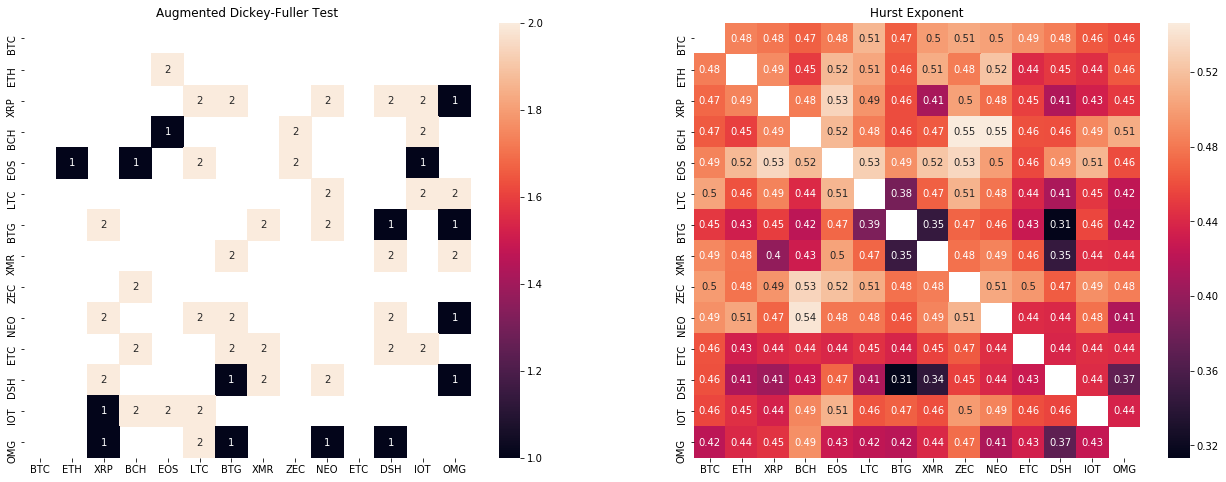

In [18]:
fig = plt.figure(figsize=(22,8))
ax1 = fig.add_subplot(121)
ax1.set_title('Augmented Dickey-Fuller Test')
ax2 = fig.add_subplot(122)
ax2.set_title('Hurst Exponent')
sns.heatmap(results_table.values.astype(float), xticklabels = results_table.columns, yticklabels = results_table.columns, annot = True, ax=ax1)
sns.heatmap(Hurst_results_table.values.astype(float), xticklabels = Hurst_results_table.columns, yticklabels = Hurst_results_table.columns, annot = True, ax=ax2);

As we can see there are __several good options ("1" or "2" in Dickey-Fuller and < 0.5 in Hurst Exponent).__ Since the goal of this project is to identify the cointegrating pairs and not to choose the absolute optimal combination we will just print the residual price series of 3 of this pairs and pick one to go forward.

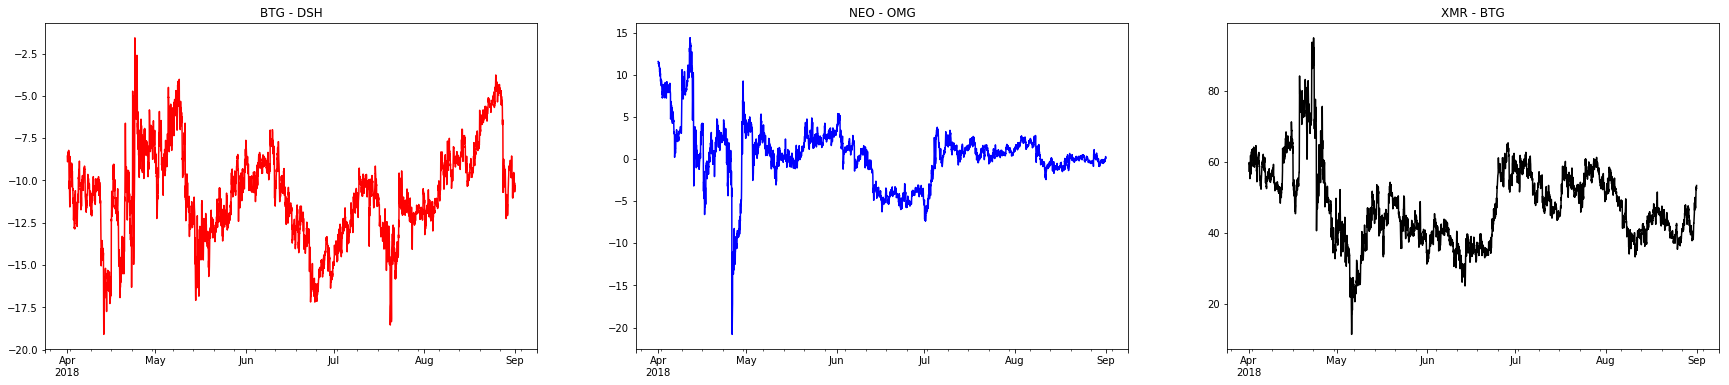

In [19]:
fig = plt.figure(figsize=(30,6))
ax1 = fig.add_subplot(131)
ax1.set_title('BTG - DSH')
ax2 = fig.add_subplot(132)
ax2.set_title('NEO - OMG')
ax3 = fig.add_subplot(133)
ax3.set_title('XMR - BTG')

regression = sm.OLS(df['BTG'], sm.add_constant(df['DSH'])).fit().params    
residual = df['BTG']-regression[1]*df['DSH']
residual.plot(ax=ax1, color='red')

regression = sm.OLS(df['NEO'], sm.add_constant(df['OMG'])).fit().params    
residual = df['NEO']-regression[1]*df['OMG']
residual.plot(ax=ax2, color='blue')

regression = sm.OLS(df['XMR'], sm.add_constant(df['BTG'])).fit().params    
residual = df['XMR']-regression[1]*df['BTG']
residual.plot(ax=ax3, color='black');

__Let's now explore the higher dimensions by looking at the results of the Johansen Test.__ Since we are adding more dimensions we should expect to have more and better results, meaning that we should expect to see series with better mean-reverting behaviour. __We will start by visualizing the top 6 price series with higher Trace test.__

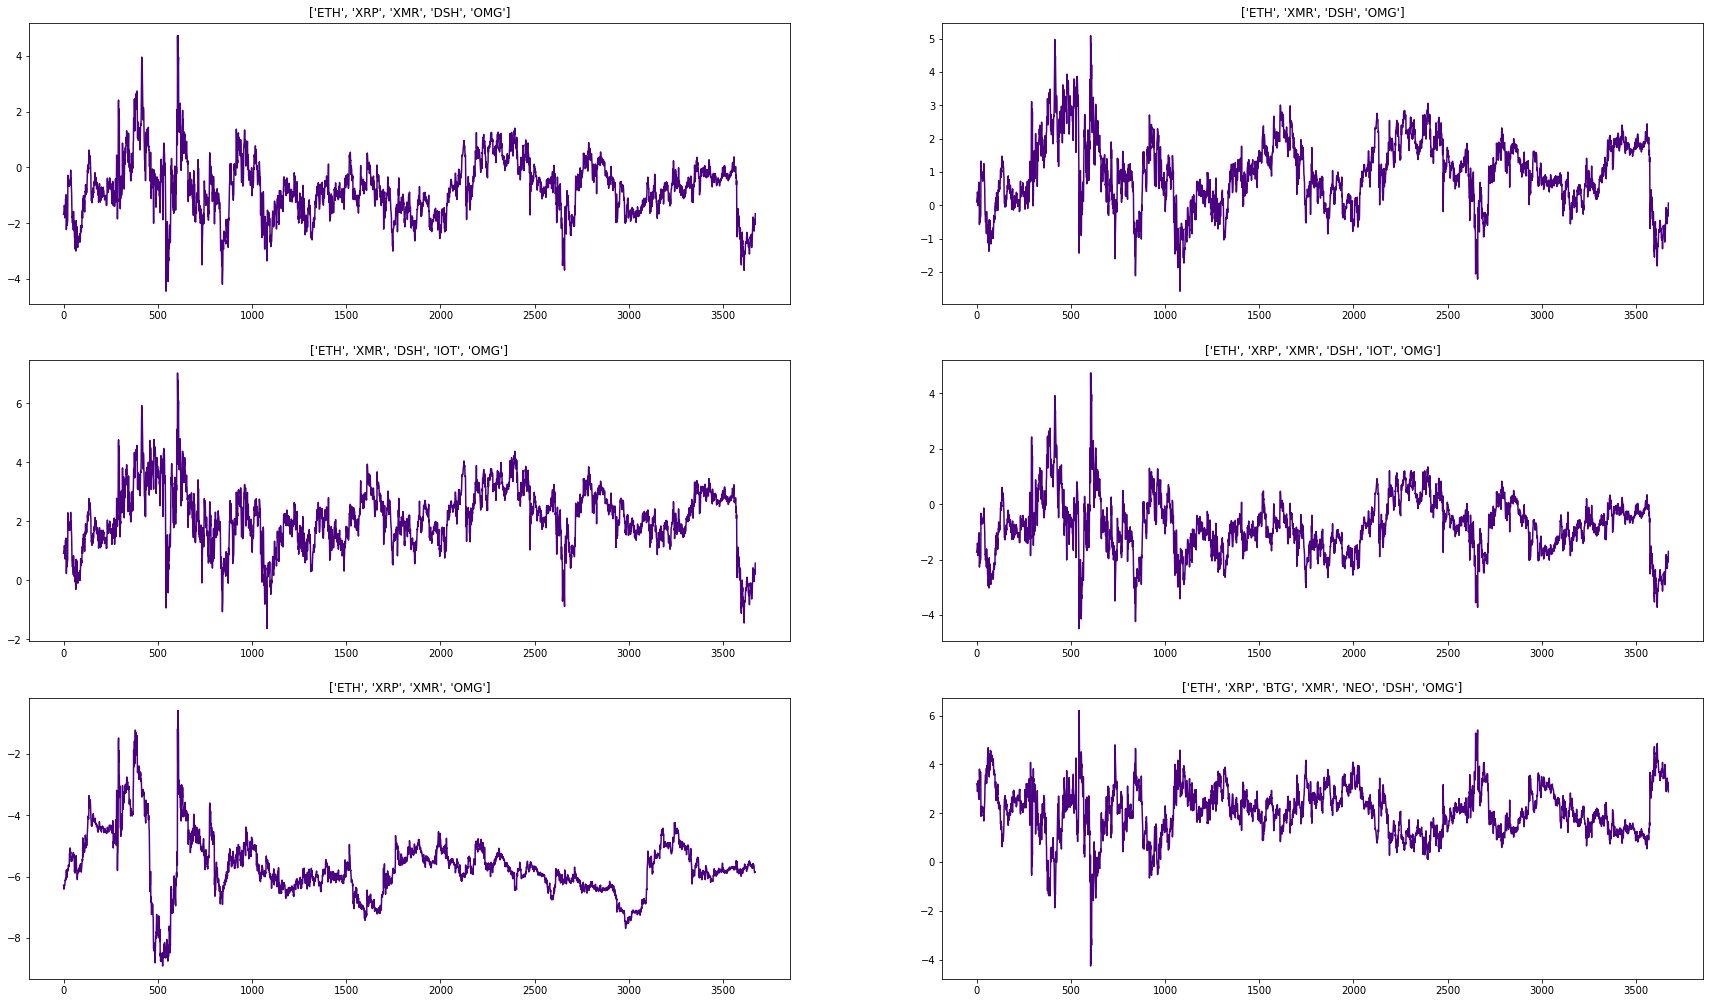

In [20]:
fig = plt.figure(figsize=(30,30))

sorted_df
for idg in range(0,6):
    tokens = list(sorted_df.index[idg])
    df_slice = df[tokens]
    eigen_vectors_slice = sorted_df['Eigen Vector'][idg]
    series = (np.dot(df_slice, eigen_vectors_slice))
    ax = fig.add_subplot(5,2,idg+1)
    ax.set_title(tokens)
    plt.plot(series, color='indigo')

### Choosing 2 price series

We will choose one series involving 2 tokens (Cointegrating Pairs) and one series with higher dimension. They are:

#### 1)       __BTG__ + 0.171313 * __DSH__  

In [21]:
first = ['BTG','DSH']
regression = sm.OLS(df['BTG'], sm.add_constant(df['DSH'])).fit().params    
first_series = df['BTG']-regression[1]*df['DSH']
title1 = (first[0] + ' + ' + str(np.around(regression[1], decimals=6)) + ' * ' + first[1])
first_df = pd.DataFrame(columns=[title1], index=df.index, data=first_series)

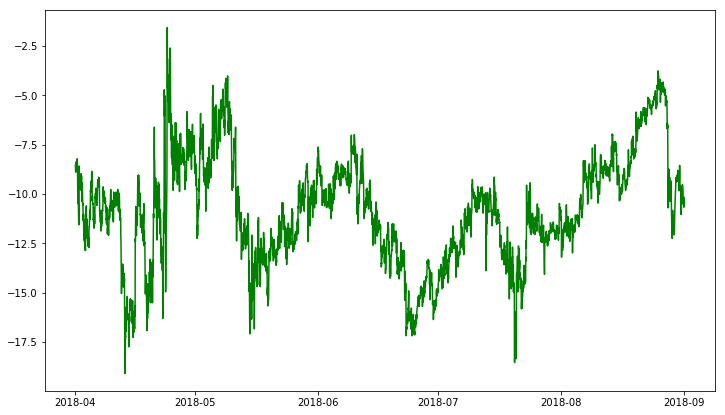

In [22]:
fig = plt.figure(figsize=(12,7))
plt.plot(first_df, color='green');

Let's have another look at the __Dickey-Fuller p-value and the Hurst Exponent of this series__

In [23]:
fir_adf = adfuller(first_series)
fir_hurst = hurst(first_series)
print('The Dickey-Fuller Test t-statistic is ' + str(np.around(fir_adf[0],4)) + ', which is smaller than the 1% critical value of ' + str(np.around(fir_adf[4]['1%'],4)))
print('The Dickey-Fuller Test p-value is ' + str(np.around(fir_adf[1],4)) + ', which is smaller than 0.05')
print('The Hurst Exponent value is ' + str(np.around(fir_hurst,4)) + ', which is much smaller than 0.5')

The Dickey-Fuller Test t-statistic is -3.5166, which is smaller than the 1% critical value of -3.4321
The Dickey-Fuller Test p-value is 0.0076, which is smaller than 0.05
The Hurst Exponent value is 0.3143, which is much smaller than 0.5




#### 2)   0.008474 * __ETH__ + 0.110181 * __XMR__ - 0.098357 * __DSH__ + 0.871111 * __OMG__

In [24]:
second = ('ETH', 'XMR', 'DSH', 'OMG')
second_vector = sorted_df['Eigen Vector'][second]
second_series = np.dot(df[list(second)], second_vector)
title2 = (str(second_vector[0]) + ' * ' + second[0] + ' + ' +\
          str(second_vector[1]) + ' * ' + second[1] + ' + ' +\
          str(second_vector[2]) + ' * ' + second[2] + ' + ' +\
          str(second_vector[3]) + ' * ' + second[3])
second_df = pd.DataFrame(columns=[title2], index=df.index, data=second_series)

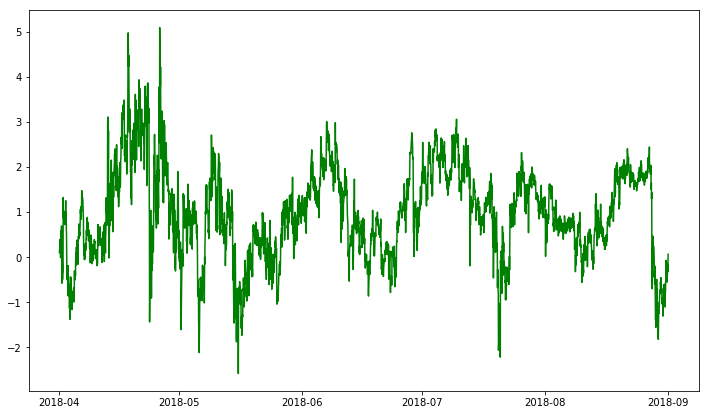

In [25]:
fig = plt.figure(figsize=(12,7))
plt.plot(second_df, color='green');

Let's have a look at the __Dickey-Fuller p-value and the Hurst Exponent of this series__

In [26]:
sec_adf = adfuller(second_series)
sec_hurst = hurst(second_series)
print('The Dickey-Fuller Test t-statistic is ' + str(np.around(sec_adf[0],4)) + ', which is smaller than the 1% critical value of ' + str(np.around(sec_adf[4]['1%'],4)))
print('The Dickey-Fuller Test p-value is ' + str(np.around(sec_adf[1],4)) + ', which is smaller than 0.05')
print('The Hurst Exponent value is ' + str(np.around(sec_hurst,4)) + ', which is much smaller than 0.5')

The Dickey-Fuller Test t-statistic is -3.8864, which is smaller than the 1% critical value of -3.4321
The Dickey-Fuller Test p-value is 0.0021, which is smaller than 0.05
The Hurst Exponent value is 0.289, which is much smaller than 0.5


#### Save Results for next notebook

In [27]:
first_df.to_csv('first.csv')
second_df.to_csv('second.csv')

## __Conclusions__

In this notebook we were able to __confirm our intuition that there are cointegration relationships__ between cryptocurrencies price series. We found several portfolios from 2 to 7 dimensions that resulted on series that exhibit strong stationarity and mean-reversion.

The selected series are ideal candidates to build a trading strategy based on more advanced techniques such as Kalman Filters. We will implement and backtest our trading strategy on the next notebook.

Finally, we should consider that __our study was performed on data over a 5 months period only__, and that further analysis over longer time frames is reccommended.

## __Written By__

__Javier Albert__  
jav.albert@gmail.com  
__Last Edit:__ 04 Sept 2018